In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Import order product dataset
df = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])
df.head()

,order_id,product_id
0,10,24
1,10,83
2,10,16
3,10,24
4,10,83


In [3]:
# Import product label mapping
products = pd.read_csv('products.csv')
products.head()

,product_id,department_id,product_name
0,61,19,cookies cakes
1,104,13,spices seasonings
2,94,7,tea
3,38,1,frozen meals
4,5,13,marinades meat preparation


In [4]:
# Merge product labels
df = pd.merge(df, products, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df.head()

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables


In [5]:
# Get modes and unique values
df.astype(object).describe()

,order_id,product_name
count,2019501,2019501
unique,200000,134
top,790903,fresh fruits
freq,137,226039


In [6]:
# Check product frequencies
df['product_name'].value_counts()

fresh fruits                  226039
fresh vegetables              212611
packaged vegetables fruits    109596
yogurt                         90751
packaged cheese                61502
                               ...  
kitchen supplies                 561
baby bath body care              515
baby accessories                 504
beauty                           387
frozen juice                     279
Name: product_name, Length: 134, dtype: int64

In [7]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Check in how many orders was product yogurt sold
pt['yogurt'].sum()

52735.0

In [9]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)


In [10]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
124,"(fresh vegetables, yogurt, packaged vegetables...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
114,"(fresh vegetables, packaged vegetables fruits,...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
34,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
119,"(fresh vegetables, packaged vegetables fruits,...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,0.022750,2.667284


In [11]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
28,"(fresh vegetables, fresh fruits)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221
31,(fresh herbs),"(fresh vegetables, fresh fruits)",0.093005,0.317560,0.061815,0.664642,2.092964,0.032280,2.034958
30,(fresh vegetables),"(fresh fruits, fresh herbs)",0.444360,0.070135,0.061815,0.139110,1.983463,0.030650,1.080121
29,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
133,"(fresh fruits, packaged vegetables fruits)","(fresh vegetables, yogurt)",0.269870,0.144660,0.076240,0.282506,1.952899,0.037201,1.192122


#### Rules are of type `frozenset`, which is a Python built-in type that behaves similarly to sets except that it is immutable. Frozensets have functions to check if there are subsets, supersets, etc. More info at https://www.journaldev.com/22850/python-frozenset


### EXPLORE FREQUENT_ITEMSETS

In [12]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.2)]

,support,itemsets,length
75,0.317560,"(fresh vegetables, fresh fruits)",2
85,0.269870,"(fresh fruits, packaged vegetables fruits)",2
100,0.234555,"(fresh vegetables, packaged vegetables fruits)",2


In [13]:
# fresh fruits and yogurt
frequent_itemsets[ frequent_itemsets['itemsets'] == {'yogurt', 'fresh fruits'}]

,support,itemsets,length
91,0.188225,"(yogurt, fresh fruits)",2


In [14]:
# packaged cheese
frequent_itemsets[ frequent_itemsets['itemsets'] == {'packaged cheese'}]

,support,itemsets,length
34,0.230995,(packaged cheese),1


In [15]:
# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.44436,0.061815,0.881372,1.983463,0.030650,4.683872
34,(fresh herbs),(fresh vegetables),0.093005,0.44436,0.078655,0.845707,1.903203,0.037327,3.601205


In [16]:
# High Confidence rules where "fresh vegetables" and "fresh fruits" are in the LHS
rulesConfidence[rulesConfidence['antecedents']=={'fresh vegetables', 'fresh fruits'}]  # Because rules are a "frozenset" object, the order of items is not important

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
74,"(fresh vegetables, fresh fruits)",(packaged vegetables fruits),0.31756,0.365415,0.18658,0.587543,1.607877,0.070539,1.538546


In [17]:
# High Confidence rules where "packaged vegetables fruits" is in the RHS
rulesConfidence[['packaged vegetables fruits' in elem for elem in rulesConfidence['consequents']]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
118,"(fresh vegetables, fresh fruits, packaged cheese)",(packaged vegetables fruits),0.104570,0.365415,0.068325,0.653390,1.788077,0.030114,1.830833
123,"(fresh vegetables, yogurt, fresh fruits)",(packaged vegetables fruits),0.118420,0.365415,0.076240,0.643810,1.761860,0.032968,1.781592
113,"(fresh vegetables, fresh fruits, milk)",(packaged vegetables fruits),0.099590,0.365415,0.062535,0.627924,1.718387,0.026143,1.705527
107,"(fresh vegetables, soy lactosefree)",(packaged vegetables fruits),0.094120,0.365415,0.057695,0.612994,1.677528,0.023302,1.639729
86,"(frozen produce, fresh fruits)",(packaged vegetables fruits),0.089235,0.365415,0.054415,0.609794,1.668772,0.021807,1.626284
109,"(fresh vegetables, yogurt)",(packaged vegetables fruits),0.144660,0.365415,0.087995,0.608288,1.664651,0.035134,1.620031
104,"(fresh vegetables, packaged cheese)",(packaged vegetables fruits),0.135850,0.365415,0.081970,0.603386,1.651235,0.032328,1.600007
62,"(fresh vegetables, eggs)",(packaged vegetables fruits),0.084310,0.365415,0.050675,0.601056,1.644858,0.019867,1.590660
52,"(fresh vegetables, bread)",(packaged vegetables fruits),0.091590,0.365415,0.053835,0.587783,1.608534,0.020367,1.539442
74,"(fresh vegetables, fresh fruits)",(packaged vegetables fruits),0.317560,0.365415,0.186580,0.587543,1.607877,0.070539,1.538546


In [18]:
# Substitue products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
111,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
110,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
230,"(fresh vegetables, fresh fruits)",(water seltzer sparkling water),0.317560,0.193005,0.063235,0.199128,1.031723,0.001944,1.007645
235,(water seltzer sparkling water),"(fresh vegetables, fresh fruits)",0.193005,0.317560,0.063235,0.327634,1.031723,0.001944,1.014983
82,(fresh fruits),(water seltzer sparkling water),0.555995,0.193005,0.111045,0.199723,1.034807,0.003735,1.008395
83,(water seltzer sparkling water),(fresh fruits),0.193005,0.555995,0.111045,0.575348,1.034807,0.003735,1.045573
133,(water seltzer sparkling water),(packaged vegetables fruits),0.193005,0.365415,0.073715,0.381933,1.045204,0.003188,1.026725
132,(packaged vegetables fruits),(water seltzer sparkling water),0.365415,0.193005,0.073715,0.201730,1.045204,0.003188,1.010929
58,(ice cream ice),(fresh fruits),0.110510,0.555995,0.064485,0.583522,1.049509,0.003042,1.066094
59,(fresh fruits),(ice cream ice),0.555995,0.110510,0.064485,0.115981,1.049509,0.003042,1.006189


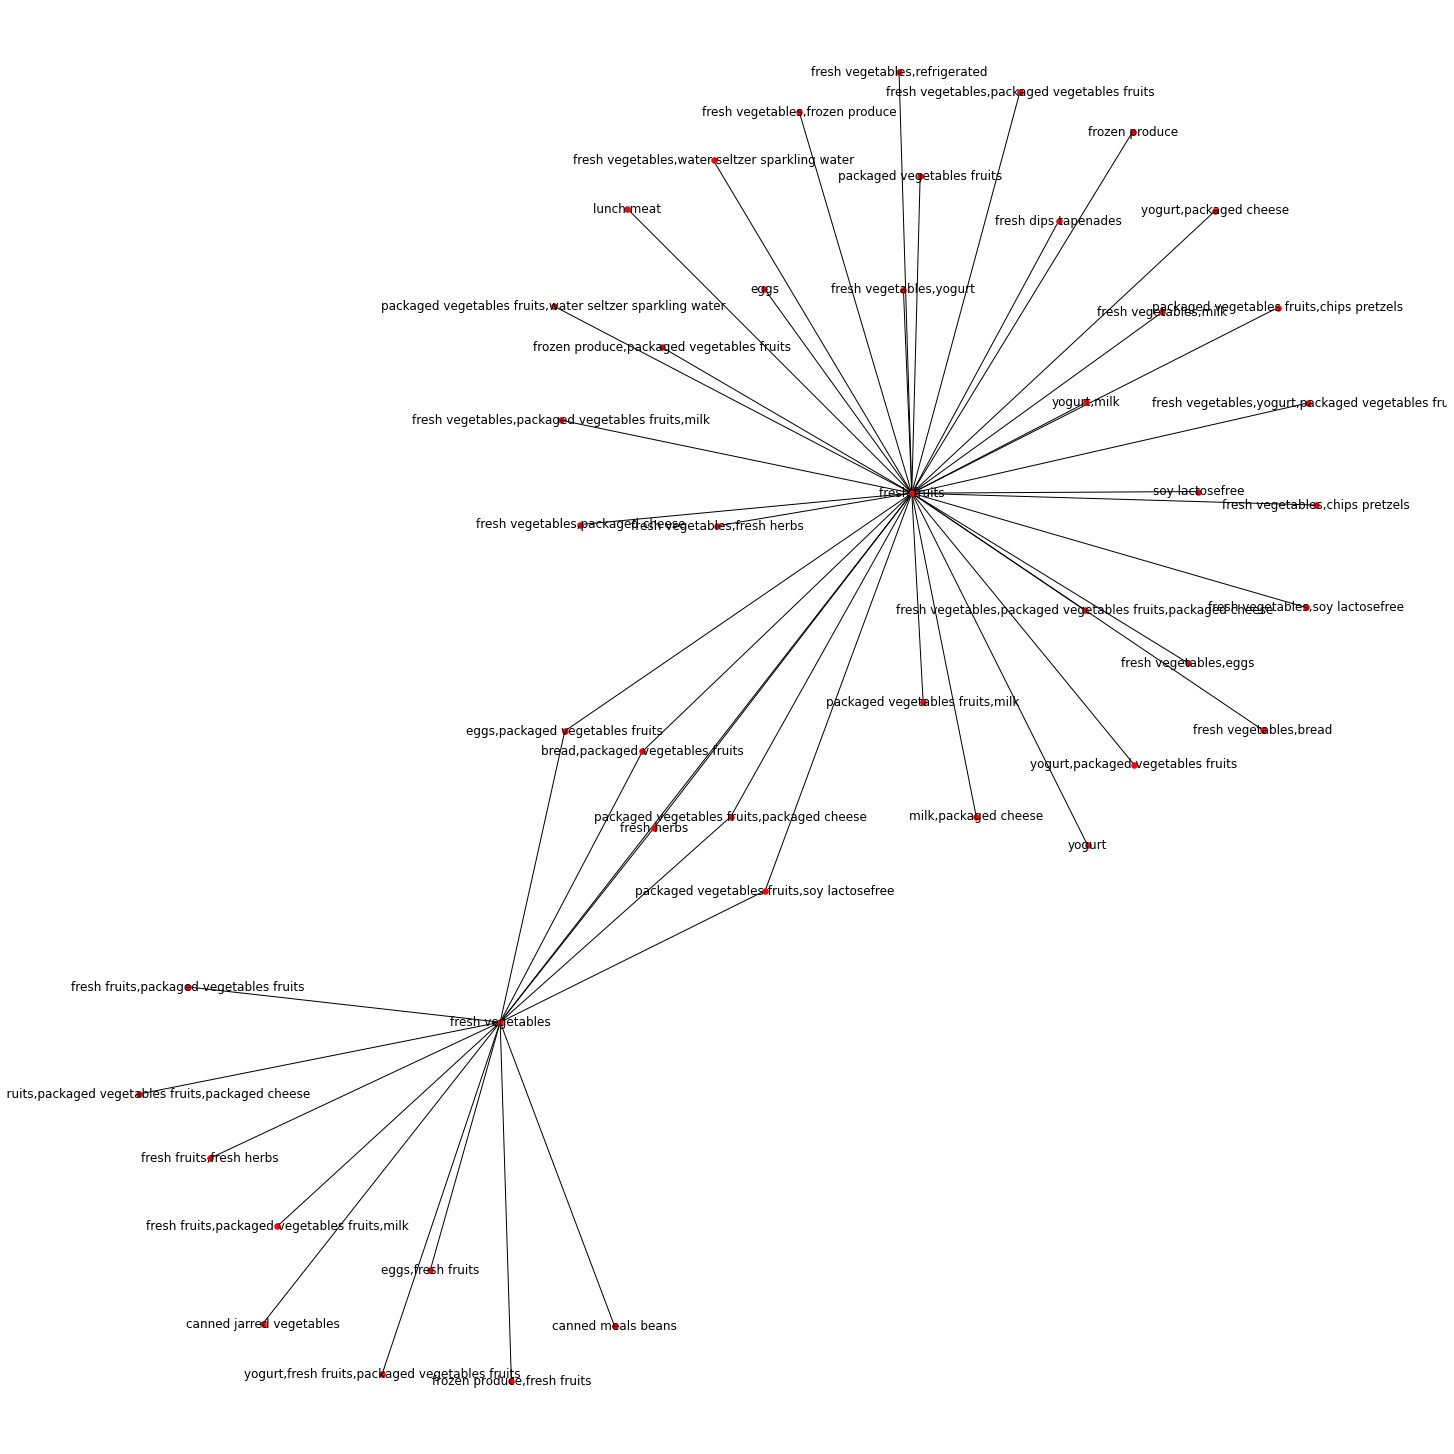

In [19]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET